# Particle tracking and residence times

In [1]:

# Filter warnings (before imports)
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pkg_resources # Must be placed after DeprecationWarning as it is itself deprecated
warnings.filterwarnings('ignore', message='.*pkg_resources.*')
warnings.filterwarnings('ignore', message='.*declare_namespace.*')

# Libraries installed by default
import sys
import os

# Libraries need to be installed if not
import numpy as np
import pandas as pd

# Libraries added from 'conda install' procedure
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import rasterio
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import flopy
import imageio

import whitebox
wbt = whitebox.WhiteboxTools()
wbt.verbose = False



In [2]:

from os.path import dirname, abspath
root_dir = '/home/agauvain/Git/HydroModPy'
sys.path.append(root_dir)
print("Root path directory is: {0}".format(root_dir.upper()))



Root path directory is: /HOME/AGAUVAIN/GIT/HYDROMODPY


In [3]:

import src
import importlib
importlib.reload(src)

# Import HydroModPy modules
from src import watershed_root
from src.display import visualization_results, export_vtuvtk
from src.tools import toolbox, folder_root

fontprop = toolbox.plot_params(8,15,18,20) # small, medium, interm, large



In [4]:

example_path = os.path.join(root_dir, "examples", "06_particle tracking and residence times/")
data_path = os.path.join(example_path, "data/")

# The folder out_path is created in the example_path root directory:
out_path = os.path.join(root_dir,'examples', 'results')
# Or use a function to update the root folder
# out_path = folder_root.update_root_folder_results()
# Or define it manually
# out_path = 'C:/Simulations/HydroModPy/'

print('The results of the example will be saved here :', out_path)



The results of the example will be saved here : /home/agauvain/Git/HydroModPy/examples/results


In [5]:

case = 'Example_06_Lasset'
# case = 'Example_06_Hillslope_1D'
# case = 'Example_06_Hillslope_2D'

if case == 'Example_06_Hillslope1D':
    dem_path = data_path + 'hillslope_1D.tif'
    load = False
    watershed_name = case
    from_lib = None # os.path.join(root_dir,'watershed_library.csv')
    from_dem = [dem_path, 10] # [path, cell size]
    from_shp = None # [path, buffer size]
    from_xyv = None # [x, y, snap distance, buffer size]
    bottom_path = None # path
    modflow_path = os.path.join(root_dir,'bin/')
    save_object = True
    
if case == 'Example_06_Hillslope2D':
    dem_path = data_path + 'hillslope_2D.tif'
    load = False
    watershed_name = case
    from_lib = None # os.path.join(root_dir,'watershed_library.csv')
    from_dem = [dem_path, 10] # [path, cell size]
    from_shp = None # [path, buffer size]
    from_xyv = None # [x, y, snap distance, buffer size]
    bottom_path = None # path
    modflow_path = os.path.join(root_dir,'bin/')
    save_object = True

if case == 'Example_06_Lasset':
    dem_path = data_path + 'regional dem.tif'
    load = True
    watershed_name = case
    from_lib = None # os.path.join(root_dir,'watershed_library.csv')
    from_dem = None # [path, cell size]
    from_shp = None # [path, buffer size]
    from_xyv = [601020,6193860,200,50,'EPSG:2154'] # [x, y, snap distance, buffer size]
    bottom_path = None # path
    modflow_path = os.path.join(root_dir,'bin/')
    save_object = True



In [6]:

print('##### '+watershed_name.upper()+' #####')

# load = True
BV = watershed_root.Watershed(dem_path=dem_path,
                              out_path=out_path,
                              load=load,
                              watershed_name=watershed_name,
                              from_lib=from_lib, # os.path.join(root_dir,'watershed_library.csv')
                              from_dem=from_dem, # [path, cell size]
                              from_shp=from_shp, # [path, buffer size]
                              from_xyv=from_xyv, # [x, y, snap distance, buffer size]
                              bottom_path=bottom_path, # path 
                              save_object=save_object)

# Paths generated automatically but necessary for plots
stable_folder = out_path+'/'+watershed_name+'/'+'results_stable/'
simulations_folder = out_path+'/'+watershed_name+'/'+'results_simulations/'



##### EXAMPLE_06_LASSET #####
      __  __          __           __  ____          ________     
     / / / /         / /          /  \/   /         / / __  /     
    / /_/ /_  ______/ /________  /       /___  ____/ / /_/ /_  __ 
   / __  / / / / __  / ___/ __ \/ /\,-/ / __ \/ __  / ____/ / / / 
  / / / / /_/ / /_/ / /  / /_/ / /   / / /_/ / /_/ / /   / /_/ /  
 /_/ /_/\__, /_____/_/   \____/_/   /_/\____/_____/_/____\__, /   
       /____/ Hydrological Modelling in Python /_____________/    
                                                                  
Python object was successfully loaded as requested; imported from output directory


In [7]:

# # Necessary to set model parameters
BV.add_climatic()

# Different cases of recharge implementation
time_series = pd.Series([10,20,30,40,50,60,60,50,40,30,20,10])
BV.climatic.update_recharge(time_series, sim_state='transient')
fig, ax = plt.subplots(1,1, figsize=(6,3))
R = BV.climatic.recharge
r = R * 0.1
ax.plot(R, label='recharge_manual', c='dodgerblue', lw=2)
ax.plot(r, label='runoff_manual', c='navy', lw=2)
ax.set_xlabel('Months')
ax.set_ylabel('[mm/month]')
ax.legend()



Init climatic module to set model parameter


In [8]:

# Frame settings
model_name = 'default'
box = True # or False
sink_fill = False # or True
sim_state = 'steady' # 'steady' or 'transient'
plot_cross = True
dis_perlen = False

# Climatic settings
recharge = pd.Series([10,20,30,40,50,60,60,50,40,30,20,10])/30/1000
first_clim = 'mean' # or 'first or value
freq_time = 'M'

# Hydraulic settings
nlay = 10
lay_decay = 1.5 # 1 for no decay
bottom = 1000 # elevation in meters, None for constant auifer thickness, or 2D matrix
thick = 100 # if bottom is None, aquifer thickness
hk = 1e-6 * 24 * 3600 # m/day
cond_drain = None # or value of conductance
sy = 1 / 100 # -
ss = 1e-10

# Boundary settings
bc_left = None # or value
bc_right = None # or value
sea_level = 'None' # or value based on specific data : BV.oceanic.MSL



In [9]:

# Import modules
BV.add_settings()
BV.add_climatic()
BV.add_hydraulic()

# Frame settings
BV.settings.update_model_name(model_name)
BV.settings.update_box_model(box)
BV.settings.update_sink_fill(sink_fill)
BV.settings.update_simulation_state(sim_state)
BV.settings.update_check_model(plot_cross=plot_cross)

# Climatic settings
BV.climatic.update_recharge(recharge, sim_state=sim_state)
BV.climatic.update_first_clim(first_clim)

# Hydraulic settings
BV.hydraulic.update_nlay(nlay) # 1
BV.hydraulic.update_lay_decay(lay_decay) # 1
BV.hydraulic.update_bottom(bottom) # None
BV.hydraulic.update_thick(thick) # 30 / intervient pas si bottom != None
BV.hydraulic.update_hk(hk)
BV.hydraulic.update_sy(sy)
BV.hydraulic.update_ss(ss)
BV.hydraulic.update_cond_drain(cond_drain)
BV.hydraulic.update_hk_decay(1/50, min_value=1e-10*24*3600, log_transf=False)

# Boundary settings
BV.settings.update_bc_sides(bc_left, bc_right)
BV.add_oceanic(sea_level)
BV.settings.update_dis_perlen(dis_perlen=dis_perlen)



Init settings module to set model parameter
Init climatic module to set model parameter
Init hydraulic module to set model parameter


In [10]:

model_modflow = BV.preprocessing_modflow(for_calib=False)
success_modflow = BV.processing_modflow(model_modflow, write_model=True, run_model=True)
if success_modflow == True:
    BV.postprocessing_modflow(model_modflow,
                              watertable_elevation = True,
                              watertable_depth= True, 
                              seepage_areas = True,
                              outflow_drain = True,
                              groundwater_flux = True,
                              groundwater_storage = True,
                              accumulation_flux = True,
                              persistency_index = False,
                              intermittency_monthly = False,
                              intermittency_daily = False,
                              export_all_tif = False)



Check model grid: total number of problematic cells is 3889
FloPy is using the following executable to run the model: ../../../../../bin/linux/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: default.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/01/09 11:59:38

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/01/09 11:59:39
 Elapsed run time:  0.991 Seconds

  Normal termination of simulation
 Post-processing:  Stress period:    1  /  1
   Export watertable elevation
   Export watertable depth
   Expor

In [11]:

# Prepare particle tracking from seepage inside the catchment studied
tif_seep = BV.simulations_folder + '/' + model_name + '/_postprocess/_rasters/seepage_areas_t(0).tif'
tif_seep_clip = BV.simulations_folder + '/' + model_name + '/_postprocess/_rasters/seepage_areas_t(0)_clip.tif'
wbt.clip_raster_to_polygon(
    tif_seep, 
    BV.stable_folder + '/geographic/watershed.shp', 
    tif_seep_clip, 
    maintain_dimensions=True)
        
# Prepare particle tracking from synthetic boreoles across the catchment
bore = imageio.imread(BV.geographic.watershed_box_buff_dem)
bore = bore*0
bore[26,34] = 1
bore[20,20] = 1
bore[40,48] = 1
bore[38,22] = 1
bore[28,21] = 1
particles_folder = os.path.join(BV.simulations_folder + '/' + model_name, '_postprocess', '_particles')
toolbox.create_folder(particles_folder)
toolbox.export_tif(BV.geographic.watershed_box_buff_dem,
                   bore,
                   BV.geographic.simulations_folder+'/'+model_name+'/'+'_postprocess/_particles/'+'synthetic_boreholes.tif',
                   0)
tif_bore = BV.geographic.simulations_folder+'/'+model_name+'/'+'_postprocess/_particles/'+'synthetic_boreholes.tif'

BV.settings.update_input_particles(#zone_partic = tif_seep,
                                   zone_partic = tif_bore,
                                   cell_div = 1, # 1
                                   zloc_div = True,  # or True, add cells at cell bottom
                                   bore_depth = True, # '[0,5,10] for 3 particles or None
                                   track_dir = 'backward',
                                   # track_dir = 'forward',
                                   sel_random = None, # or int
                                   sel_slice = None, # or int
                                   )

if sim_state == 'steady':
    if success_modflow == True:
        model_modpath = BV.preprocessing_modpath(model_modflow)
        success_modpath = BV.processing_modpath(model_modpath, write_model=True, run_model=True)
    if success_modpath == True:
        BV.postprocessing_modpath(model_modpath,
                                  ending_point=True,
                                  starting_point=True,
                                  pathlines_shp=True,
                                  particles_shp=False,
                                  random_id=None, # select randomly to save (for pathlines and particles)
                                  ) # None
        
        BV.filtprocessing_modpath(model_modpath,
                                  norm_flux=True, # for forward only
                                  filt_time=True, # delete particles with time at 0, add a column with time divided by 365 (considering recharge in days)
                                  filt_seep=True, # only forward, keep only particles finishing in zone1 (seepage), keep only particles finishing in k1 (first layer)
                                  filt_inout=True, # delete particles in and out in the same cell (first layer)
                                  calc_rtd=True, # compute residence time distribution
                                  random_id=None, # select randomly to keep
                                  ) # None



writing loc particle data
FloPy is using the following executable to run the model: ../../../../../bin/linux/mp6
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.
(numpy.record, [('particleid', '<i4'), ('particlegroup', '<i4'), ('timepointindex', '<i4'), ('cumulativetimestep', '<i4'), ('time', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('grid', '<i4'), ('xloc', '<f4'), ('yloc', '<f4'), ('zloc', '<f4'), ('linesegmentindex', '<i4')])


In [12]:

timeseries_results = BV.postprocessing_timeseries(model_modflow=model_modflow,
                                                  model_modpath=model_modpath,
                                                  datetime_format=False, 
                                                  subbasin_results=True) # or None



   Export results as timeseries


In [13]:

# if sim_state == 'steady':
visu = visualization_results.Visualization(BV, model_name)
visu.visual2D(object_list = ['map','grid',
                             'watertable', 'watertable_depth',
                             'drain_flow','surface_flow',
                             'pathlines', 'residence_times'
                             ],
              color_scale = [(None,None),(None,None),
                             (None,None),(0,10),
                             (None,None),(None,None),
                             (0,100),(None,None),
                             ], 
              lines=500)



  Plot 2D maps visualization


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

In [14]:

lead_numb = '0'
outflow = imageio.imread(simulations_folder+model_name+'/_postprocess/_rasters/accumulation_flux_t(0).tif')
demData = imageio.imread(BV.geographic.watershed_dem)
demData = np.ma.masked_array(demData, mask=demData<0)
res = BV.geographic.resolution

msk_outflow = (outflow<0)
outflow = np.ma.masked_array(outflow, mask=msk_outflow)
outflow = ( np.ma.masked_where(outflow==0, outflow) / (res**2) )
outflow = outflow * 1000 * 365 # mm/year
outflow = np.log10(outflow)

from matplotlib.colors import LightSource
ls = LightSource(azdeg=45, altdeg=45)
cmap = plt.cm.Greys
rgb = ls.shade(demData, cmap=cmap, blend_mode='soft', vert_exag=2, dx=res, dy=res)

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
im = ax.imshow(demData, alpha=0.8, cmap=cmap)
im = ax.imshow(rgb, alpha=0.8, cmap=cmap)
cf=ax.imshow(outflow, cmap='YlGnBu', alpha=1, vmin=outflow.min(), vmax=outflow.max())
ax.set_title('Seepage outflow (quick view)')

name_fig = 'map_discharge_' + str(lead_numb) + '.png'
plt.tight_layout()

# fig.savefig(os.path.join(simulations_folder, model_name,
#                             '_postprocess', '_figures', 'RAW_'+model_name+'.png'))



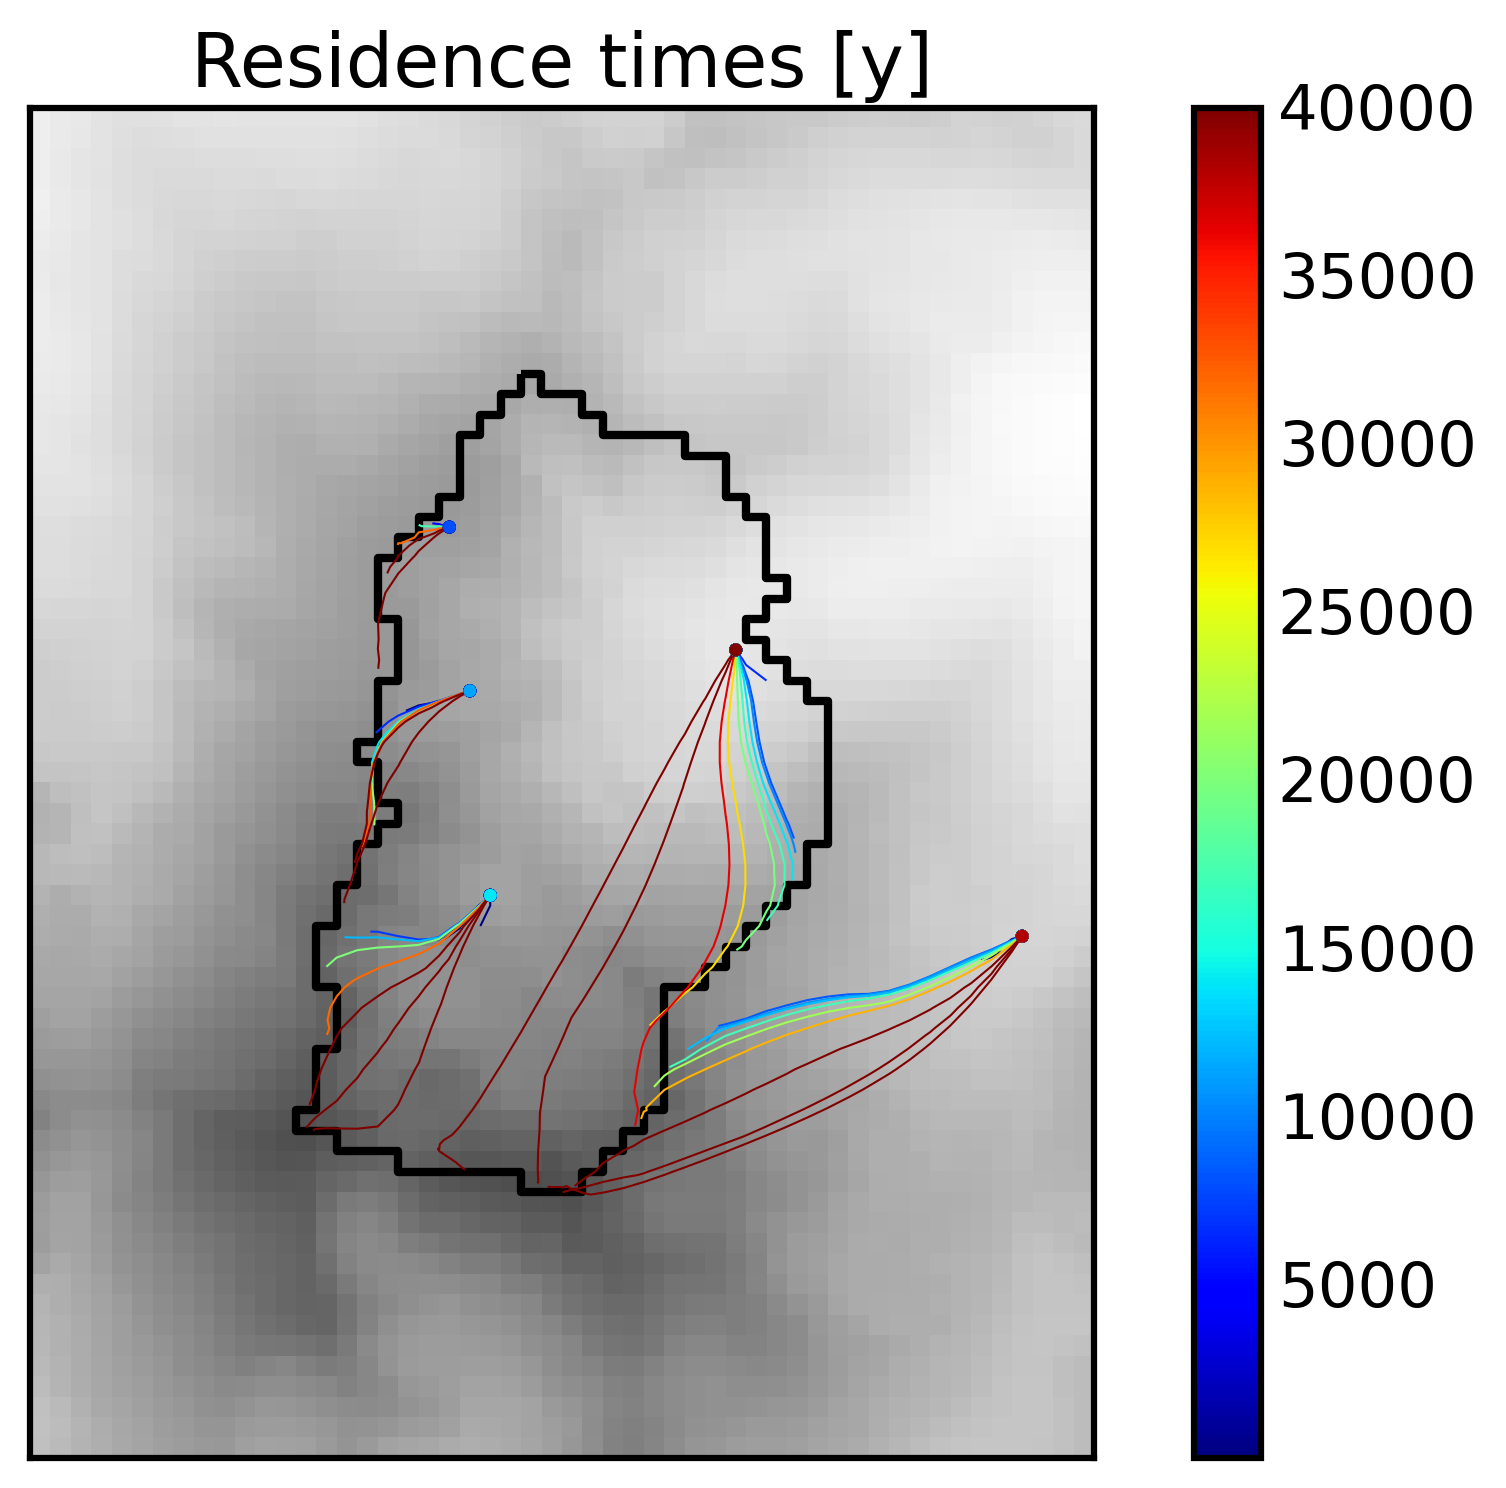

In [15]:

shp_pathlines = gpd.read_file(simulations_folder+model_name+'/_postprocess/_particles/pathlines_weighted.shp')
# shp_endpoints = gpd.read_file(simulations_folder+model_name+'/_postprocess/_particles/starting_weighted.shp')
shp_endpoints = gpd.read_file(simulations_folder+model_name+'/_postprocess/_particles/starting_weighted.shp')

try:
    line = gpd.read_file(stable_folder+'geographic/'+'watershed_contour.shp')
except:
    pass

dem_rio = rasterio.open(BV.geographic.watershed_box_buff_dem)
dem_data = dem_rio.read(1)
dem_data = np.ma.masked_where(dem_data < 0, dem_data)

fig, ax = plt.subplots(1,1, figsize=(7,5))

rasterio.plot.show(dem_data, ax=ax, transform=dem_rio.transform, 
                    cmap='Greys', alpha=0.7, zorder=-10)

shp_pathlines.plot(ax=ax, column='time_win_y', cmap='jet', lw=0.5,
                   norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
                   zorder=1)

shp_endpoints.plot(ax=ax, column='time_win_y', cmap='jet', lw=0, markersize=10,
                   # norm=mpl.colors.LogNorm(vmin=0.1, vmax=1000),
                   legend=True,
                   zorder=2)

try:
    line.plot(ax=ax, color='k', lw=2, zorder=-1)
except:
    pass

ax.set_title('Residence times [y]')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)  

fig.tight_layout()

# fig.savefig(os.path.join(simulations_folder, model_name,
#                             '_postprocess', '_figures', 'RTD_'+model_name+'.png'))



In [16]:

os.chdir(root_dir)

# wbt.geomorphons(
#     'xxx/watershed_box_buff_dem.tif', 
#     'xxx/watershed_box_geomorphons.tif', 
#     search=5, # in cell
#     threshold=0, # angle in degree
#     fdist=0, # in cell  
#     skip=0, # in cell
#     forms=True, 
#     residuals=False, 
# )


